# 장애인콜택시 대기시간 예측
## 단계2. 탐색적 데이터 분석

## 0.미션

* 1.개별 변수 분석하기
    * 앞서 생성된 각 변수들 특히 추가로 생성한 변수들에 대해서 단변량 분석을 수행합니다.
    * 시각화 : Histogram, Boxplot, Barplot
    * 통계량 : 기초 통계량.
    * [옵션] 날짜 요소 관점을 추가해서 EDA 를 수행하시오.
* 2.Features와 Target의 관계 분석하기
    * Target은 숫자입니다.
    * 숫자형 feature들과 Target 과의 관계
        * 한꺼번에 상관관계를 확인하는 방법을 이용하여 분석합시다.
    * 범주형 feature들과 Target
        * sns.barplot, t-검정, 분산분석 등을 이용하여 분석합니다.
    * Target과 관련이 높은 feature와 그렇지 않은 feature를 정리해 봅시다.

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고,
            * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 설치 및 로딩
        * requirements.txt 파일로 부터 라이브러리 설치
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [ ]:
# path = 'C:/Users/User/project/'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst
import joblib

In [53]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

open_data = '/content/drive/MyDrive/KTaivle/2차미니프로젝트/open_data.csv'
weather = '/content/drive/MyDrive/KTaivle/2차미니프로젝트/weather.csv'

open_data = pd.read_csv(open_data, sep=',', encoding='utf-8', index_col=0)
weather = pd.read_csv(weather, sep=',', encoding='utf-8', index_col=0)
open_data.index.name = 'Date'
# 아래에 실습코드를 작성하고 결과를 확인합니다.

new_columns = {
    '차량운행': 'vehicle_operation',
    '접수건': 'receipt_count',
    '탑승건': 'boarding_count',
    '평균대기시간': 'average_waiting_time',
    '평균요금': 'average_fare',
    '평균승차거리': 'average_distance'
}

open_data.rename(columns=new_columns, inplace=True)
df = open_data.copy()
df['Date'] = df.index
df['Date'] = pd.to_datetime(df['Date'])

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['weekday'] = df['Date'].dt.dayofweek

df['ratio'] = df['boarding_count']/df['receipt_count']
df_weather = weather.copy()
df_weather = df_weather.shift(1)
df['target'] = df['average_waiting_time'].shift(-1)
merged_df = pd.merge(df, df_weather, left_index=True, right_index=True, how='inner')
merged_df.drop(labels='Date', axis=1, inplace=True)
merged_df['Date'] = merged_df.index
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['weekday'] = merged_df['Date'].dt.day_name()

# 요일별로 정렬
merged_df['weekday'] = pd.Categorical(merged_df['weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
merged_df['season'] = merged_df['month'].apply(lambda x: 'Spring' if x in [3, 4, 5] else ('Summer' if x in [6, 7, 8] else ('Fall' if x in [9, 10, 11] else 'Winter')))
merged_df['season'] = pd.Categorical(merged_df['season'], categories=['Spring', 'Summer', 'Fall', 'Winter'])

merged_df.drop(labels='Date', axis=1, inplace=True)
!pip install workalendar
from workalendar.asia import SouthKorea

cal = SouthKorea()
holiday = pd.DataFrame()
for y in range(2015, 2023) :
    holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

holiday.columns = ['Date', 'holiday']
holiday['Date'] = pd.to_datetime(holiday['Date'])
holiday['holiday'] = 1
holiday.set_index('Date', inplace=True)

print(merged_df)
print(holiday)
merged_df.index = pd.to_datetime(merged_df.index)
holiday.index = pd.to_datetime(holiday.index)
merged_df = pd.merge(merged_df, holiday, how='left', left_index=True, right_index=True)
merged_df = merged_df.fillna({'holiday':0})
merged_df['7days'] = merged_df['average_waiting_time'].rolling(window=7).mean()
merged_df['ratio2'] = merged_df['boarding_count']/merged_df['receipt_count']
merged_df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=3cb5c90ae7719974e3825db84b02152ece87256d530cf1061fe57ac045ae1352
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus
            vehicle_operation  receipt_count  boarding_count  \
Date                                                           
2015-01-01                213           1023             924   
2015-01-02                420           3158            2839   
2015-01-03                209           1648            1514   
2015-01-04                196           1646            1526   
2015-01-05                421           4250  

,vehicle_operation,receipt_count,boarding_count,average_waiting_time,average_fare,average_distance,year,month,day,weekday,...,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,holiday,7days,ratio2
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,2015,1,1,Thursday,...,-1.6,-1.6,0.0,64.0,64.0,0.00,Winter,1.0,NaN,0.903226
2015-01-02,420,3158,2839,17.2,2216,8611,2015,1,2,Friday,...,-4.3,-9.8,0.0,52.0,33.0,9.79,Winter,0.0,NaN,0.898987
2015-01-03,209,1648,1514,26.2,2377,10198,2015,1,3,Saturday,...,-2.0,-8.9,0.0,63.0,28.0,9.07,Winter,0.0,NaN,0.918689
2015-01-04,196,1646,1526,24.5,2431,10955,2015,1,4,Sunday,...,2.4,-9.2,0.0,73.0,37.0,8.66,Winter,0.0,NaN,0.927096
2015-01-05,421,4250,3730,26.2,2214,8663,2015,1,5,Monday,...,8.2,0.2,0.0,89.0,58.0,5.32,Winter,0.0,NaN,0.877647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,669,5635,4654,44.4,2198,8178,2022,12,27,Tuesday,...,1.5,-7.9,0.0,85.0,46.0,8.27,Winter,0.0,42.771429,0.825909
2022-12-28,607,5654,4648,44.8,2161,7882,2022,12,28,Wednesday,...,3.0,-7.3,0.0,86.0,51.0,10.25,Winter,0.0,43.514286,0.822073
2022-12-29,581,5250,4247,52.5,2229,8433,2022,12,29,Thursday,...,-0.3,-5.4,0.1,92.0,40.0,10.86,Winter,0.0,42.957143,0.808952


In [54]:
merged_df

,vehicle_operation,receipt_count,boarding_count,average_waiting_time,average_fare,average_distance,year,month,day,weekday,...,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),season,holiday,7days,ratio2
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,2015,1,1,Thursday,...,-1.6,-1.6,0.0,64.0,64.0,0.00,Winter,1.0,NaN,0.903226
2015-01-02,420,3158,2839,17.2,2216,8611,2015,1,2,Friday,...,-4.3,-9.8,0.0,52.0,33.0,9.79,Winter,0.0,NaN,0.898987
2015-01-03,209,1648,1514,26.2,2377,10198,2015,1,3,Saturday,...,-2.0,-8.9,0.0,63.0,28.0,9.07,Winter,0.0,NaN,0.918689
2015-01-04,196,1646,1526,24.5,2431,10955,2015,1,4,Sunday,...,2.4,-9.2,0.0,73.0,37.0,8.66,Winter,0.0,NaN,0.927096
2015-01-05,421,4250,3730,26.2,2214,8663,2015,1,5,Monday,...,8.2,0.2,0.0,89.0,58.0,5.32,Winter,0.0,NaN,0.877647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,669,5635,4654,44.4,2198,8178,2022,12,27,Tuesday,...,1.5,-7.9,0.0,85.0,46.0,8.27,Winter,0.0,42.771429,0.825909
2022-12-28,607,5654,4648,44.8,2161,7882,2022,12,28,Wednesday,...,3.0,-7.3,0.0,86.0,51.0,10.25,Winter,0.0,43.514286,0.822073
2022-12-29,581,5250,4247,52.5,2229,8433,2022,12,29,Thursday,...,-0.3,-5.4,0.1,92.0,40.0,10.86,Winter,0.0,42.957143,0.808952


## 2.EDA : 1단계 - 개별 정보 분석하기

* **세부요구사항**
    * 의미 있는 변수들을 7개 이상 선정하고 단변량분석을 수행합니다.
    * [옵션] 각 변수에 대한 탐색시, 요일별, 월별, 연도별로 나눠서도 확인해보세요.
    * 단변량 분석을 위한 코드를 함수로 작성하고 수행하세요.

### (1) 단변량 분석 함수 작성
* **세부요구사항**
    * 코드가 반복되므로, 시각화와 기초통계량을 한꺼번에 처리하는 함수를 생성합시다.
    * 포함되어야 할 내용 :
        * 기초통계량
            * 숫자 : .describe()
            * 범주 : 범주별 빈도수/비율
        * 시각화


In [51]:
# 숫자형 변수 분석
def eda_1_n(data, var, hue_var = ''):
    display(data[[var]].describe().T)

    if hue_var == '' :
        plt.figure(figsize = (15,10))
        plt.subplot(2,1,1)
        sns.histplot(data[var], kde = True, bins = 50)
        plt.grid()

        plt.subplot(2,1,2)
        sns.boxplot(x = data[var])
        plt.grid()
        plt.show()
    else :
        plt.figure(figsize = (15,5))
        plt.subplot(1,2,1)
        sns.kdeplot(x= var, data = data, hue = hue_var)
        plt.grid()

        plt.subplot(1,2,2)
        sns.boxplot(x = hue_var, y = var, data = data)
        plt.grid()


In [ ]:
# 범주형 변수 분석
def eda_1_c(data, var, hue_var = ''):

    cnt = data[var].value_counts()
    prop = data[var].value_counts()/data.shape[0]
    result = pd.DataFrame({'Count':cnt, 'Prop':prop})
    display(result)

    sns.countplot(x = var, data = data)
    plt.grid()
    plt.show()

### (2) 숫자형 변수
* 이제 숫자형 변수들에 대해서 단변량 분석을 수행합니다.

#### 1) 접수건

,count,mean,std,min,25%,50%,75%,max
receipt_count,2923.0,3924.83818,1510.056733,527.0,2161.0,4720.0,5110.0,6182.0


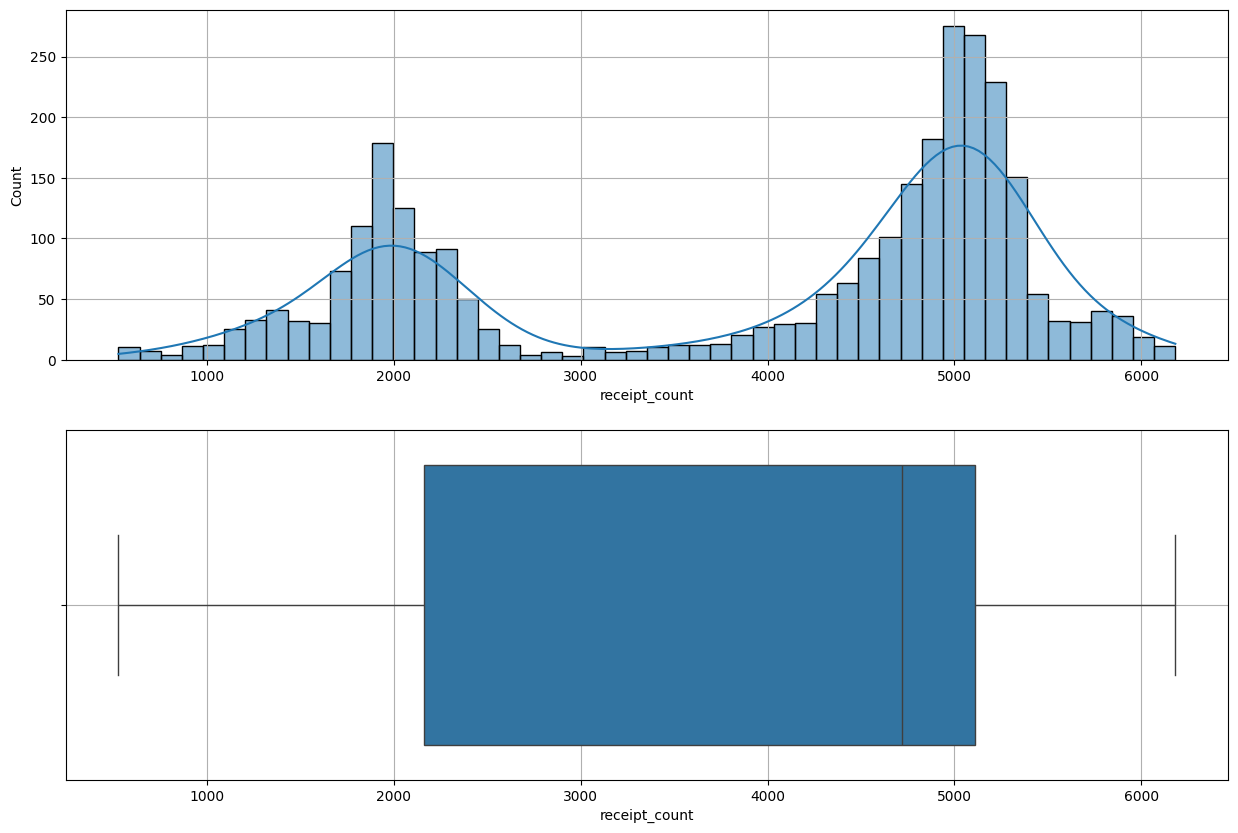

In [55]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_n(merged_df, 'receipt_count')

#### 2) 평균대기시간

,count,mean,std,min,25%,50%,75%,max
average_waiting_time,2923.0,40.300171,14.099285,17.2,29.6,38.2,48.6,96.1


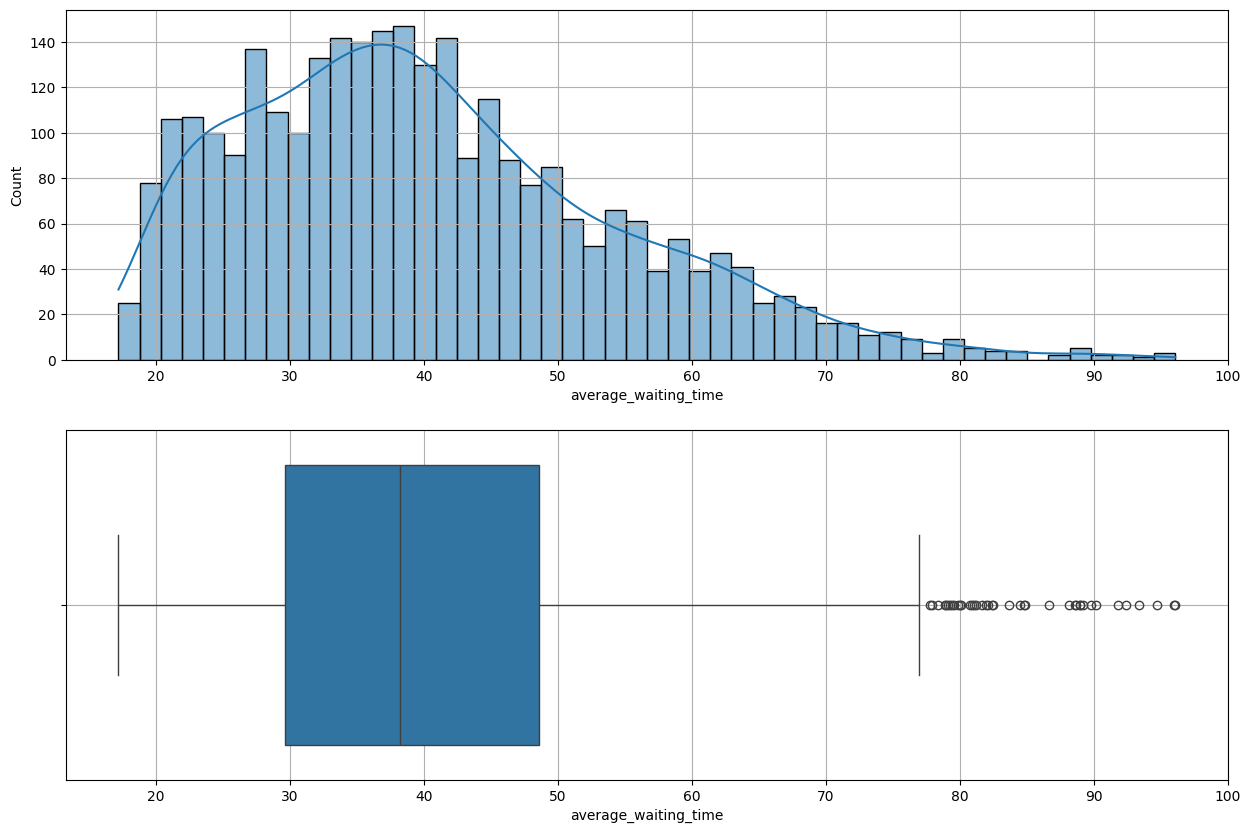

In [57]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_n(merged_df, 'average_waiting_time')

#### 3) 평균운임

,count,mean,std,min,25%,50%,75%,max
average_fare,2923.0,2304.362299,107.351769,2131.0,2228.0,2257.0,2401.0,2733.0


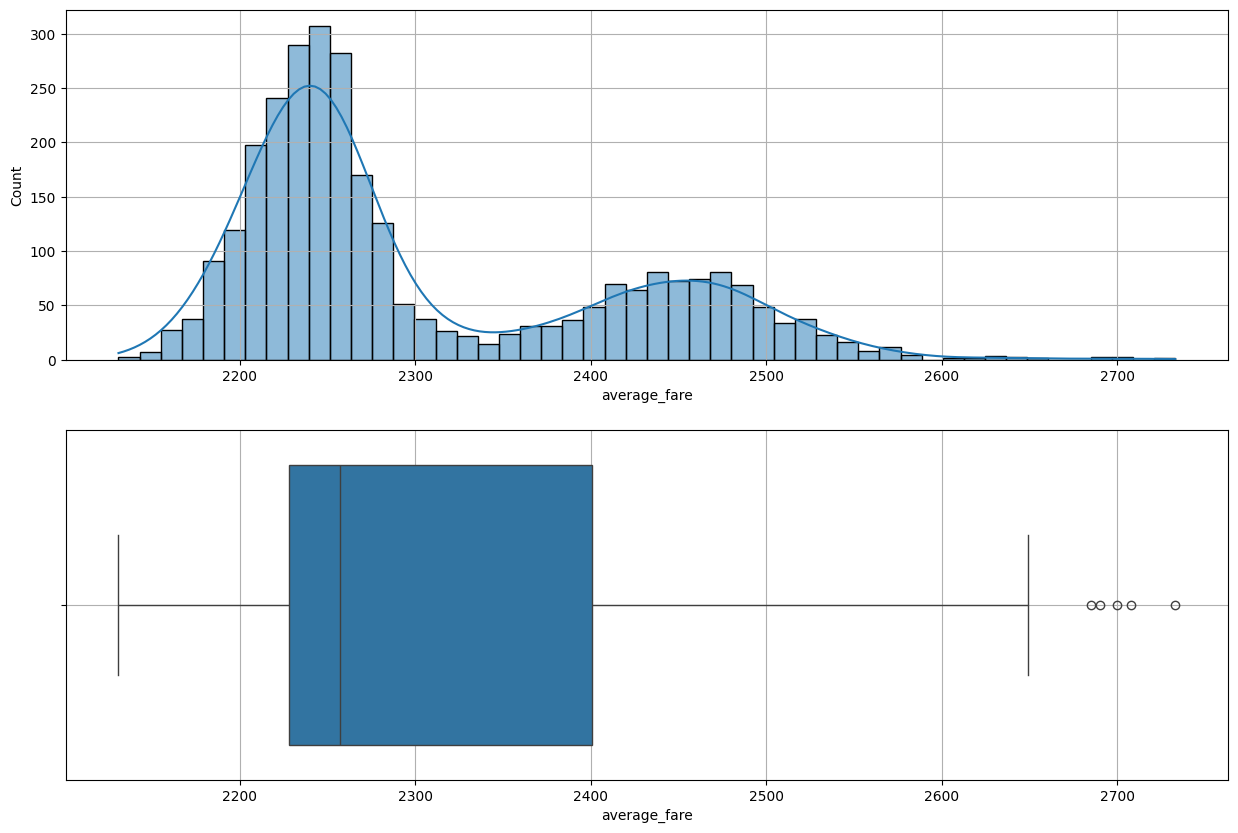

In [58]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_n(merged_df, 'average_fare')

#### 4) 평균거리

,count,mean,std,min,25%,50%,75%,max
average_distance,2922.0,9253.5,1019.198152,7672.0,8521.0,8821.5,10153.0,14136.0


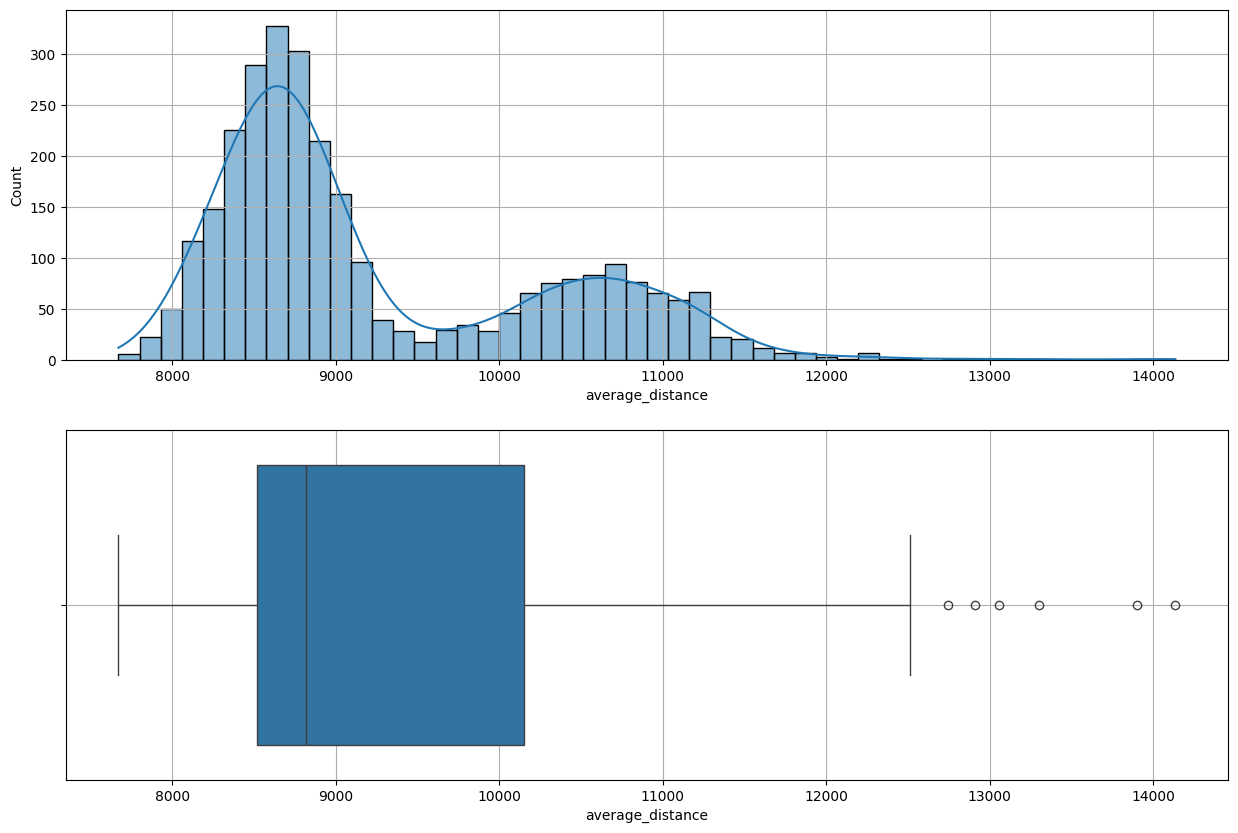

In [59]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_n(open_data, 'average_distance')

#### 5) 탑승률

,count,mean,std,min,25%,50%,75%,max
ratio,2923.0,0.841565,0.052167,0.596996,0.805964,0.845571,0.877718,0.968844


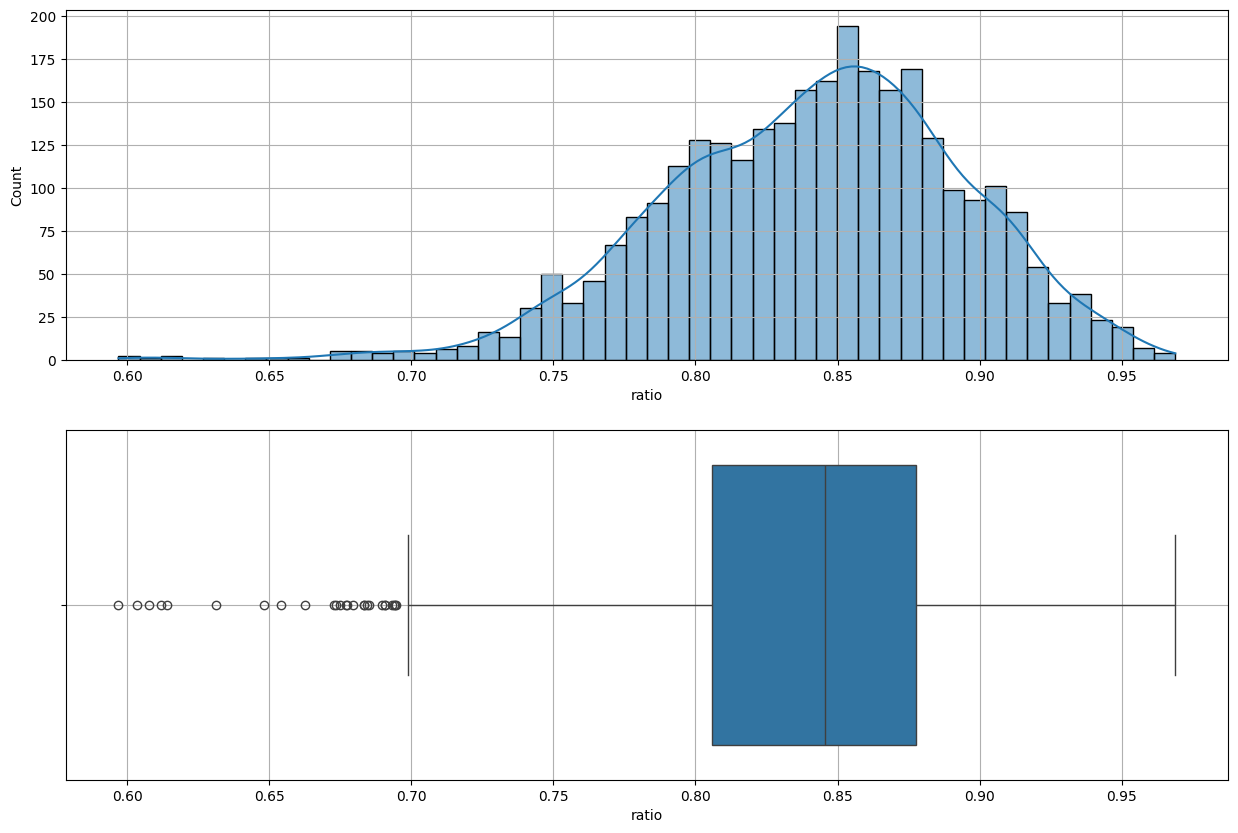

In [61]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_n(merged_df, 'ratio')

,count,mean,std,min,25%,50%,75%,max
ratio2,2923.0,0.841565,0.052167,0.596996,0.805964,0.845571,0.877718,0.968844


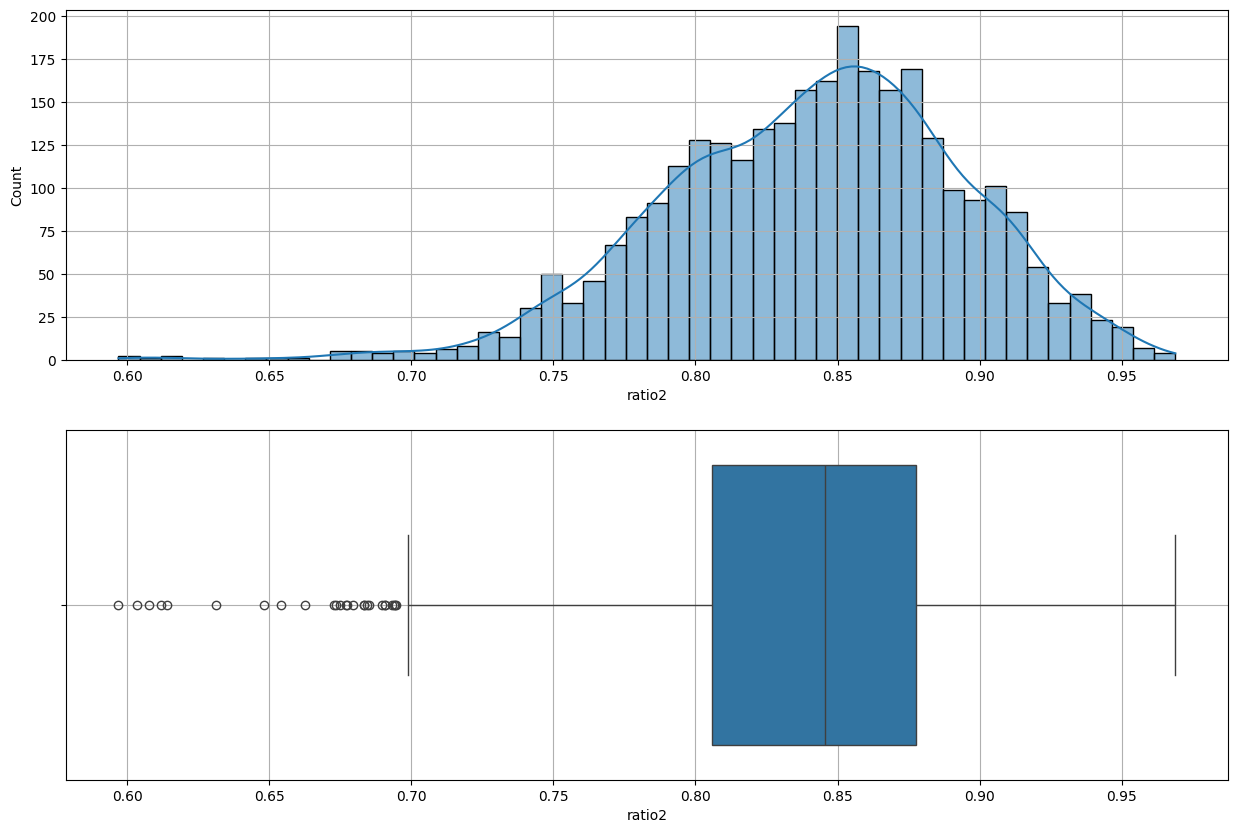

In [62]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_n(merged_df, 'ratio2')

#### 6) 최고기온(°C)

,count,mean,std,min,25%,50%,75%,max
temp_max,2923.0,18.074444,10.711013,-11.2,9.0,19.7,27.4,39.4


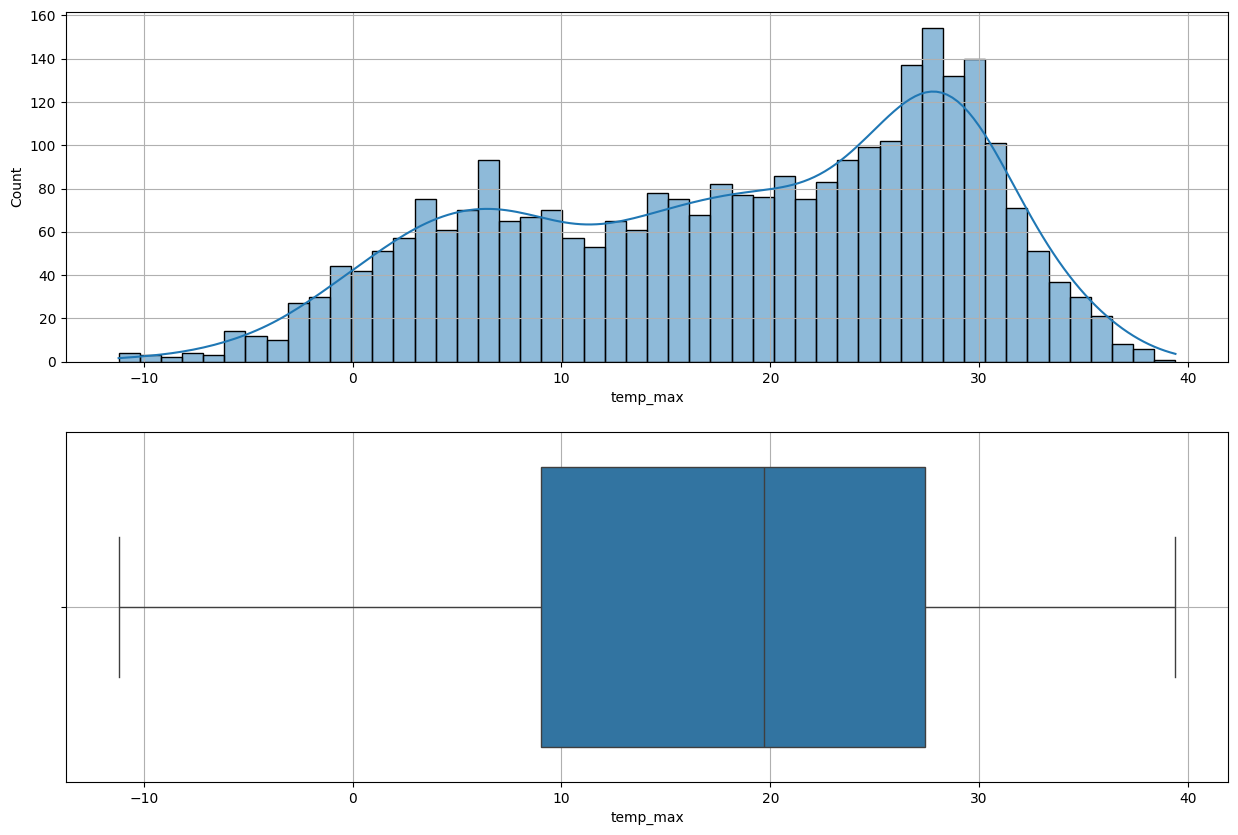

In [63]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_n(merged_df, 'temp_max')

#### 7) 일강수량(mm)

,count,mean,std,min,25%,50%,75%,max
rain(mm),2923.0,3.35532,12.593658,0.0,0.0,0.0,0.3,178.9


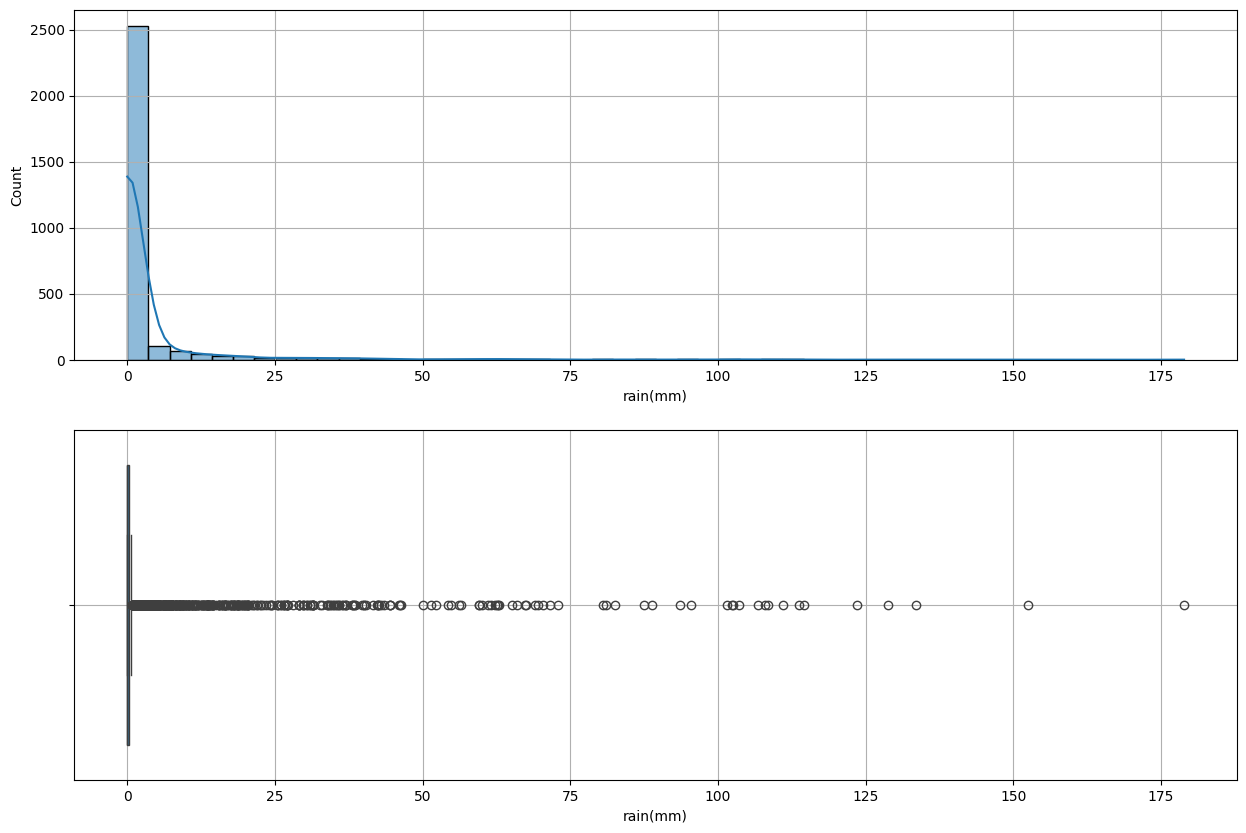

In [64]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_n(merged_df, 'rain(mm)')

### (3) 범주형 변수
* 범주형 변수들에 대해서 단변량 분석을 수행합니다.

#### 1) 공휴일 유무

,Count,Prop
0.0,2803,0.958946
1.0,120,0.041054


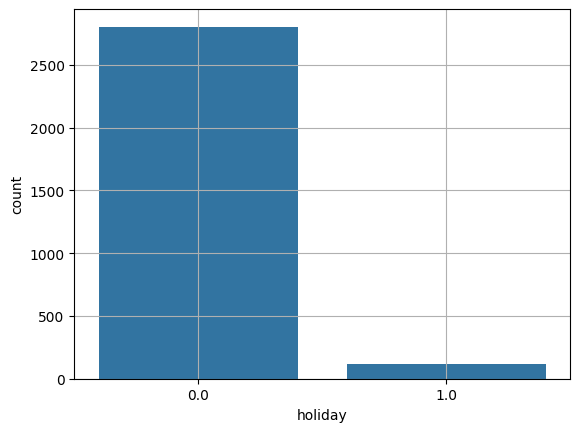

In [65]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

eda_1_c(merged_df, 'holiday')

## 3.EDA 2단계 - feature와 target 비교 분석하기

* **세부요구사항**
    * 숫자 feature --> target
        * 전체 상관계수 구하고 시각화(heatmap)해서 파악해봅시다.
        * 상위 n개의 feature와 target의 상점도를 확인해봅시다.
    * 범주 feature --> target
        * 시각화 : 평균 비교 barplot
        * 수치화 : t-test, anova
    * 이번 단계에서는 함수 생성은 선택사항 입니다.

### (1) 숫자 feature --> Target
* 전체 상관계수 시각화(heatmap)
* 상위 n개 산점도 그리기

In [68]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

corr_matrix = merged_df.corr()
n = 5
top_n_corr_features = corr_matrix['target'].sort_values(ascending=False).head(n).index.tolist()

print(top_n_corr_features)

['target', '7days', 'average_waiting_time', 'receipt_count', 'month']


<ipython-input-68-dd857f9c88ad>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_df.corr()


#### 1) 전체 상관계수 시각화

In [69]:
# 전체 상관관계를 한눈에 보여주기 함수
def eda_2_corr(data, num_vars):

    temp = data.loc[:, num_vars]
    corr = temp.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    display(mask * corr)

    sns.set(style='white')
    plt.figure(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, annot = True)
    plt.show()

,target,7days,average_waiting_time,receipt_count,month
target,1.0,0.799435,0.732416,0.316562,0.275723
7days,0.0,1.000000,0.841898,0.186525,0.326406
average_waiting_time,0.0,0.000000,1.000000,0.292297,0.282139
receipt_count,0.0,0.000000,0.000000,1.000000,0.088752
month,0.0,0.000000,0.000000,0.000000,1.000000


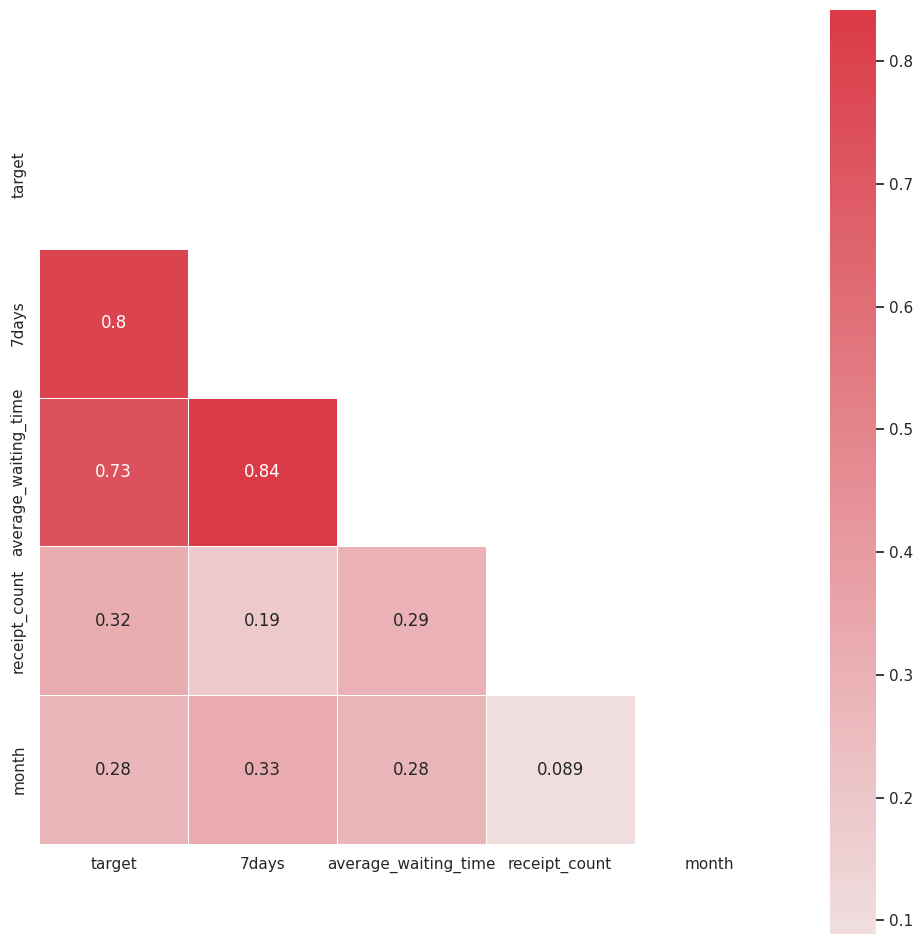

In [70]:
num_vars = ['target', '7days', 'average_waiting_time', 'receipt_count', 'month']

eda_2_corr(merged_df, num_vars)

#### 2) 산점도

In [71]:
def eda_2_nn(data, target, var, hue = ''):

    plt.figure(figsize = (8,8))
    if hue == '' :
        sns.scatterplot(x = var, y = target, data = data)
        plt.grid()

    if hue != '' :
        sns.scatterplot(x = var, y = target, data = data, hue = hue)
        plt.grid()

    plt.show()

* ride_rate

In [79]:
merged_df = merged_df.drop(columns=['ratio2'])

In [85]:
merged_df.reset_index(drop=True, inplace=True)


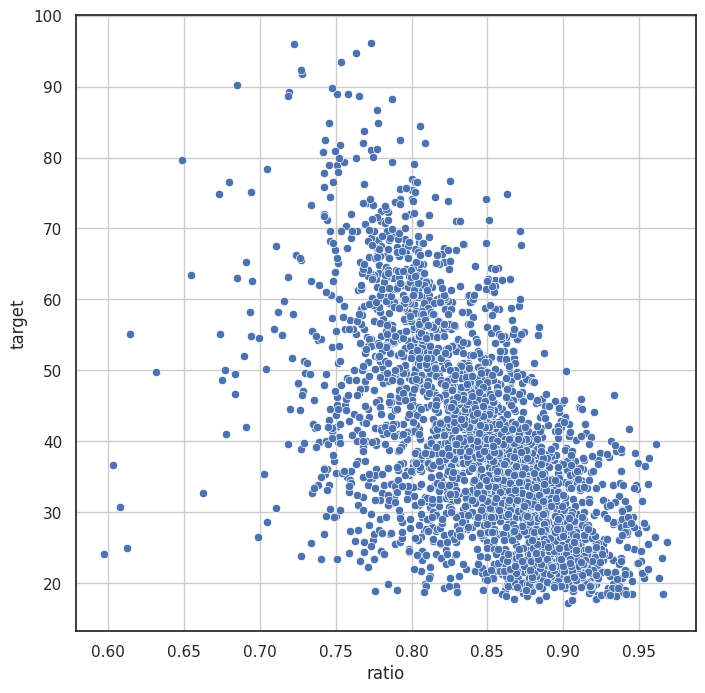

In [86]:
eda_2_nn(merged_df, 'target', 'ratio')

* fare

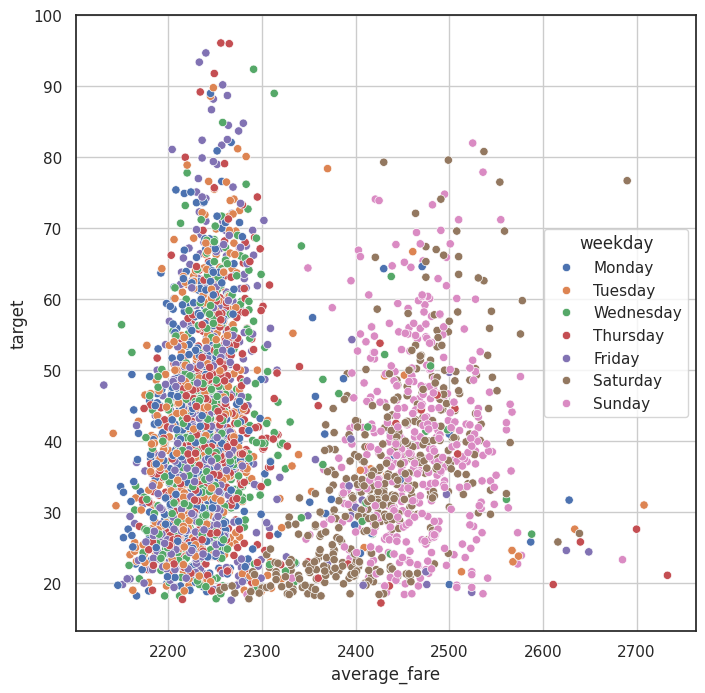

In [91]:
eda_2_nn(merged_df, 'target', 'average_fare', 'weekday')

### (2) 범주 feature --> Target

* 범주형 변수들과 target 간의 관계를 살펴봅시다.
    * 시각화 : 평균비교 barplot
    * 수치화 : t-검정, anova

* 휴일 여부

In [ ]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.



In [92]:
# t-test
h0 = merged_df.loc[merged_df['holiday']==0.0, 'target']
h1 = merged_df.loc[merged_df['holiday']==1.0, 'target']
spst.ttest_ind(h0, h1)

TtestResult(statistic=nan, pvalue=nan, df=nan)

* 요일

In [ ]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.



In [94]:
# anova
temp = merged_df.loc[merged_df['weekday'].notnull()]

w0 = temp.loc[temp['weekday']=='Monday', 'target']
w1 = temp.loc[temp['weekday']=='Tuesday', 'target']
w2 = temp.loc[temp['weekday']=='Wednesday', 'target']
w3 = temp.loc[temp['weekday']=='Thursday', 'target']
w4 = temp.loc[temp['weekday']=='Friday', 'target']
w5 = temp.loc[temp['weekday']=='Saturday', 'target']
w6 = temp.loc[temp['weekday']=='Sunday', 'target']

spst.f_oneway(w0,w1,w2,w3,w4,w5,w6)

F_onewayResult(statistic=nan, pvalue=nan)

* 계절

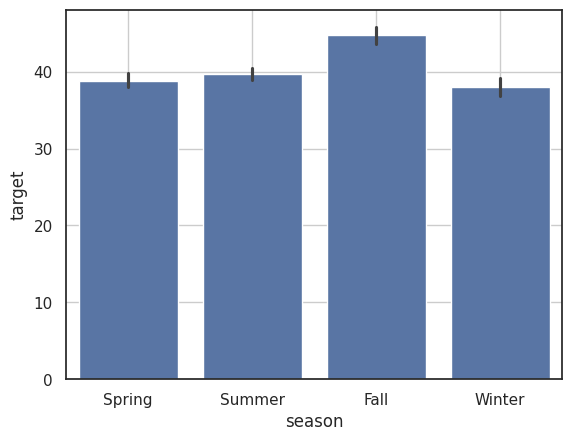

In [95]:
sns.barplot(x = 'season', y = 'target', data = merged_df)
plt.grid()
plt.show()

In [96]:
# anova
temp = merged_df.loc[merged_df['season'].notnull()]

s0 = temp.loc[temp['season']=='Spring', 'target']
s1 = temp.loc[temp['season']=='Summer', 'target']
s2 = temp.loc[temp['season']=='Fall', 'target']
s3 = temp.loc[temp['season']=='Winter', 'target']

spst.f_oneway(s0,s1,s2,s3)

F_onewayResult(statistic=nan, pvalue=nan)

## 4.변수 정리

* Target과 관련성이 높은 feature와 그렇지 않은 feature를 정리합니다.
* 여기서의 판단은 다소 주관적입니다. 조금 정확하지 않아도 괜찮습니다.
* 다음 단계 모델링에서 관련이 적은 변수는 포함시키거나, 제외를 고려할때 활용합니다.

* 강한 관계의 변수

In [ ]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.



* 중간(약한) 관계의 변수

In [ ]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.



* (거의) 관계가 없는 변수

In [ ]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.



## 5.데이터 저장

* **세부 요구사항**
    * 혹시 데이터에 변경이 발생할 수 있으니, 저장해 놓읍시다.
    * joblib.dump를 이용하시오.
    * 저장할 파일 이름 : data2.pkl

In [ ]:
# 아래에 실습코드를 작성하고 결과를 확인합니다.

